In [1]:
# Health Risk Assessment Integration
# Combine predictions with health risk module

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import sys

# Add src to path
sys.path.append('../')
from src.health_risk.risk_assessment import (
    HealthRiskCalculator, 
    format_assessment_report,
    AQICategory
)

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

print("=" * 70)
print("HEALTH RISK ASSESSMENT INTEGRATION")
print("=" * 70)

HEALTH RISK ASSESSMENT INTEGRATION


In [2]:
# =============================================================================
# 1. LOAD BEST MODEL AND TEST DATA
# =============================================================================

print("\n📂 LOADING MODEL AND DATA...")

# Load best model
model_path = Path('../data/models/best_model_gradientboosting.pkl')
with open(model_path, 'rb') as f:
    best_model = pickle.load(f)

# Load test data
test_path = Path('../data/processed/features_test.csv')
df_test = pd.read_csv(test_path)
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])

print(f"✓ Loaded model: Gradient Boosting")
print(f"✓ Test data: {len(df_test):,} records")


📂 LOADING MODEL AND DATA...
✓ Loaded model: Gradient Boosting
✓ Test data: 3,384 records


In [3]:
# =============================================================================
# 2. MAKE PREDICTIONS
# =============================================================================

print("\n🔮 GENERATING PREDICTIONS...")

# Prepare features (same as training)
import json
with open('../data/processed/feature_sets.json', 'r') as f:
    feature_sets = json.load(f)

features = feature_sets['balanced']
available_features = [f for f in features if f in df_test.columns]

X_test = df_test[available_features].fillna(df_test[available_features].median())
y_test = df_test['aqi']

# Predict
predictions = best_model.predict(X_test)
df_test['aqi_predicted'] = predictions

print(f"✓ Generated {len(predictions):,} predictions")


🔮 GENERATING PREDICTIONS...
✓ Generated 3,384 predictions


In [4]:
# =============================================================================
# 3. INITIALIZE HEALTH RISK CALCULATOR
# =============================================================================

print("\n🏥 INITIALIZING HEALTH RISK CALCULATOR...")

calculator = HealthRiskCalculator()

print("✓ Health Risk Calculator ready")



🏥 INITIALIZING HEALTH RISK CALCULATOR...
✓ Health Risk Calculator ready


In [5]:
# =============================================================================
# 4. GENERATE RISK ASSESSMENTS FOR ALL PREDICTIONS
# =============================================================================

print("\n📊 GENERATING HEALTH RISK ASSESSMENTS...")

risk_assessments = []

for idx, row in df_test.iterrows():
    aqi_pred = row['aqi_predicted']
    assessment = calculator.assess_health_risk(aqi_pred)
    
    risk_assessments.append({
        'timestamp': row['timestamp'],
        'city': row.get('city_name', 'Unknown'),
        'aqi_actual': row['aqi'],
        'aqi_predicted': aqi_pred,
        'aqi_category': assessment.aqi_category,
        'risk_level': assessment.risk_level,
        'outdoor_activity': assessment.outdoor_activity_level,
        'mask_recommendation': assessment.mask_recommendation
    })

df_risk = pd.DataFrame(risk_assessments)

print(f"✓ Generated {len(df_risk):,} risk assessments")


📊 GENERATING HEALTH RISK ASSESSMENTS...
✓ Generated 3,384 risk assessments


In [6]:
# =============================================================================
# 5. RISK ASSESSMENT STATISTICS
# =============================================================================

print("\n" + "=" * 70)
print("📊 RISK ASSESSMENT STATISTICS")
print("=" * 70)

# AQI category distribution
category_dist = df_risk['aqi_category'].value_counts()
print("\nAQI Category Distribution:")
for category, count in category_dist.items():
    pct = (count / len(df_risk)) * 100
    print(f"  {category:<35} {count:>5} ({pct:>5.1f}%)")

# Risk level distribution
risk_dist = df_risk['risk_level'].value_counts()
print("\nRisk Level Distribution:")
for risk, count in risk_dist.items():
    pct = (count / len(df_risk)) * 100
    print(f"  {risk:<20} {count:>5} ({pct:>5.1f}%)")

# City-wise risk analysis
if 'city' in df_risk.columns:
    print("\nAverage Risk by City:")
    city_risk = df_risk.groupby('city')['aqi_predicted'].agg(['mean', 'max']).round(1)
    print(city_risk.sort_values('mean', ascending=False))


📊 RISK ASSESSMENT STATISTICS

AQI Category Distribution:
  Good                                 1334 ( 39.4%)
  Moderate                              746 ( 22.0%)
  Unhealthy                             605 ( 17.9%)
  Very Unhealthy                        383 ( 11.3%)
  Unhealthy for Sensitive Groups        232 (  6.9%)
  Hazardous                              54 (  1.6%)
  Unknown                                30 (  0.9%)

Risk Level Distribution:
  Low                   2080 ( 61.5%)
  High                   605 ( 17.9%)
  Very High              383 ( 11.3%)
  Moderate               232 (  6.9%)
  Extreme                 84 (  2.5%)

Average Risk by City:
              mean    max
city                     
Delhi        207.4  304.9
Mumbai       204.1  299.8
Beijing      190.7  374.2
Cairo         98.0  182.5
Mexico City   95.0  377.0
Los Angeles   65.5  354.6
São Paulo     36.6  445.6
Tokyo         30.9  499.9
New York      25.8  494.1
London         5.2   67.8



📈 GENERATING VISUALIZATIONS


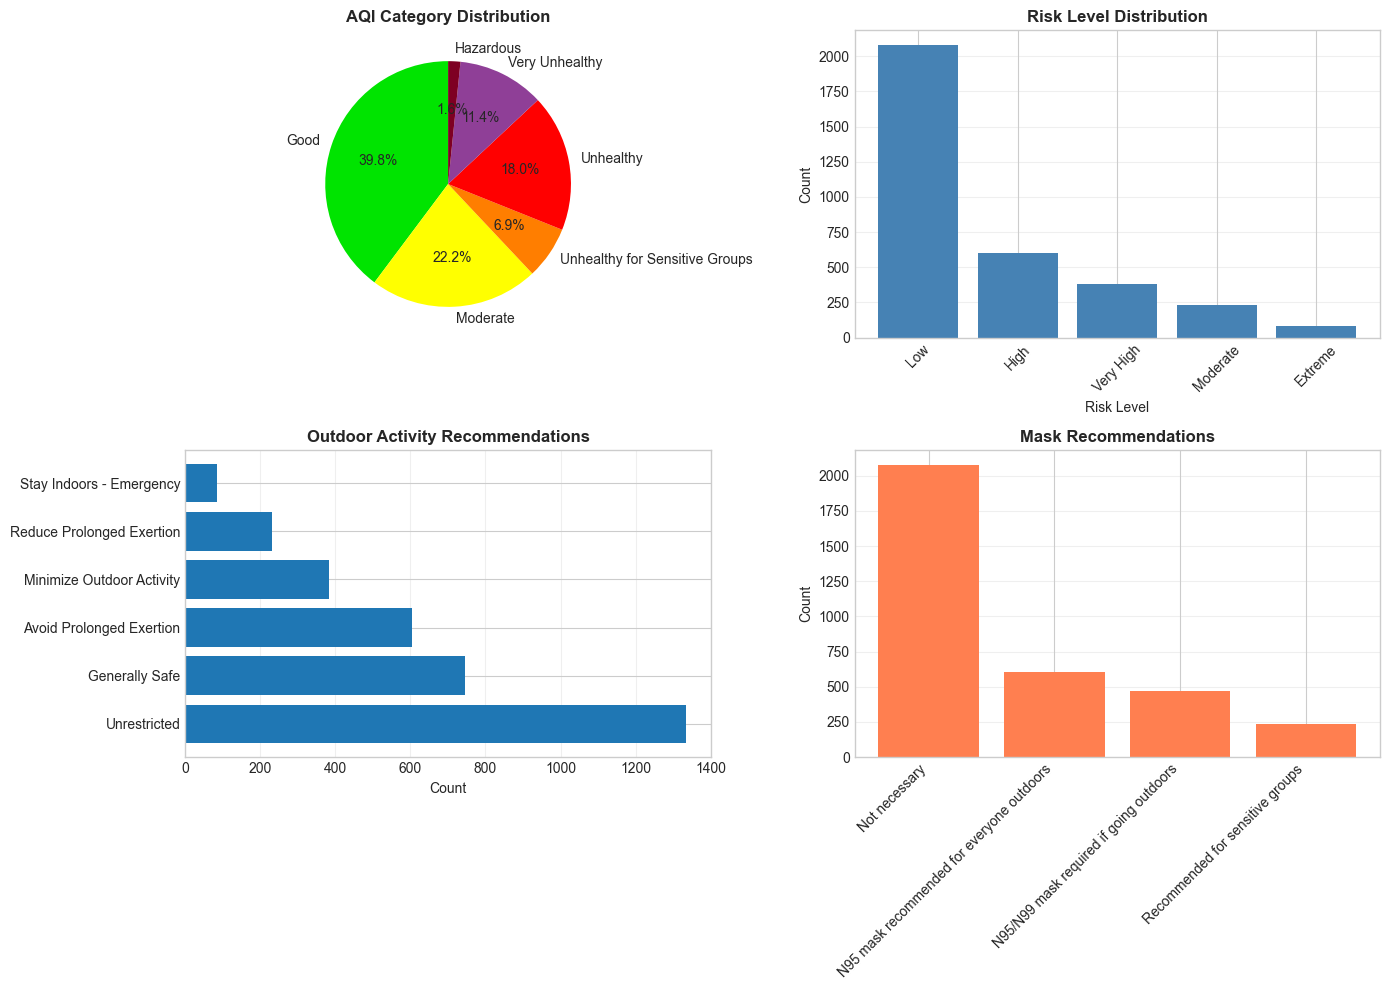

In [7]:
# =============================================================================
# 6. VISUALIZATIONS
# =============================================================================

print("\n" + "=" * 70)
print("📈 GENERATING VISUALIZATIONS")
print("=" * 70)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. AQI Category Distribution
category_colors = {
    'Good': '#00E400',
    'Moderate': '#FFFF00',
    'Unhealthy for Sensitive Groups': '#FF7E00',
    'Unhealthy': '#FF0000',
    'Very Unhealthy': '#8F3F97',
    'Hazardous': '#7E0023'
}

category_order = list(category_colors.keys())
category_counts = df_risk['aqi_category'].value_counts().reindex(category_order, fill_value=0)

colors = [category_colors.get(cat, 'gray') for cat in category_counts.index]
axes[0, 0].pie(category_counts.values, labels=category_counts.index, 
               autopct='%1.1f%%', colors=colors, startangle=90)
axes[0, 0].set_title('AQI Category Distribution', fontweight='bold')

# 2. Risk Level Distribution
axes[0, 1].bar(risk_dist.index, risk_dist.values, color='steelblue')
axes[0, 1].set_title('Risk Level Distribution', fontweight='bold')
axes[0, 1].set_xlabel('Risk Level')
axes[0, 1].set_ylabel('Count')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Outdoor Activity Recommendations
activity_dist = df_risk['outdoor_activity'].value_counts()
axes[1, 0].barh(range(len(activity_dist)), activity_dist.values)
axes[1, 0].set_yticks(range(len(activity_dist)))
axes[1, 0].set_yticklabels(activity_dist.index)
axes[1, 0].set_title('Outdoor Activity Recommendations', fontweight='bold')
axes[1, 0].set_xlabel('Count')
axes[1, 0].grid(True, alpha=0.3, axis='x')

# 4. Mask Recommendations
mask_dist = df_risk['mask_recommendation'].value_counts()
axes[1, 1].bar(range(len(mask_dist)), mask_dist.values, color='coral')
axes[1, 1].set_xticks(range(len(mask_dist)))
axes[1, 1].set_xticklabels(mask_dist.index, rotation=45, ha='right')
axes[1, 1].set_title('Mask Recommendations', fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [8]:
# =============================================================================
# 7. EXAMPLE ASSESSMENTS
# =============================================================================

print("\n" + "=" * 70)
print("📋 EXAMPLE HEALTH RISK ASSESSMENTS")
print("=" * 70)

# Get examples from different categories
examples = []
for category in ['Good', 'Moderate', 'Unhealthy', 'Hazardous']:
    matching = df_risk[df_risk['aqi_category'] == category]
    if not matching.empty:
        examples.append(matching.iloc[0])

for example in examples:
    print(f"\n{'-' * 70}")
    assessment = calculator.assess_health_risk(example['aqi_predicted'])
    print(format_assessment_report(assessment))


📋 EXAMPLE HEALTH RISK ASSESSMENTS

----------------------------------------------------------------------
HEALTH RISK ASSESSMENT REPORT

Air Quality Index: 2
Category: Good
Risk Level: Low

Health Message:
Air quality is satisfactory, and air pollution poses little or no risk.

Outdoor Activity Level: Unrestricted
Mask Recommendation: Not necessary

Recommendations:
  1. Enjoy outdoor activities!
  2. No precautions needed


----------------------------------------------------------------------
HEALTH RISK ASSESSMENT REPORT

Air Quality Index: 93
Category: Moderate
Risk Level: Low

Health Message:
Air quality is acceptable. However, there may be a risk for some people, particularly those who are unusually sensitive to air pollution.

Outdoor Activity Level: Generally Safe
Mask Recommendation: Not necessary

Recommendations:
  1. Outdoor activities are generally safe
  2. Sensitive individuals should watch for symptoms


-----------------------------------------------------------------

In [9]:
# =============================================================================
# 8. VULNERABLE GROUP ANALYSIS
# =============================================================================

print("\n" + "=" * 70)
print("🏥 VULNERABLE GROUP IMPACT ANALYSIS")
print("=" * 70)

# Simulate vulnerable group assessments
vulnerable_groups_list = [
    'children',
    'elderly',
    'asthma_patients',
    'heart_disease_patients'
]

group_impact = {}

for group in vulnerable_groups_list:
    high_risk_count = 0
    
    for aqi in df_risk['aqi_predicted']:
        assessment = calculator.assess_health_risk(aqi, vulnerable_groups=[group])
        if assessment.risk_level in ['Very High', 'Extreme']:
            high_risk_count += 1
    
    group_impact[group] = {
        'high_risk_days': high_risk_count,
        'percentage': (high_risk_count / len(df_risk)) * 100
    }

print("\nVulnerable Group High-Risk Exposure:")
for group, stats in group_impact.items():
    print(f"  {group.replace('_', ' ').title():<25} {stats['high_risk_days']:>4} days ({stats['percentage']:>5.1f}%)")



🏥 VULNERABLE GROUP IMPACT ANALYSIS

Vulnerable Group High-Risk Exposure:
  Children                  1072 days ( 31.7%)
  Elderly                   1072 days ( 31.7%)
  Asthma Patients           1072 days ( 31.7%)
  Heart Disease Patients    1072 days ( 31.7%)



⏰ BEST TIME FOR OUTDOOR ACTIVITIES

Best time for outdoor activities:
  Hour: 13:00
  Average AQI: 91.8
  Category: Moderate

Worst time (avoid outdoor activities):
  Hour: 20:00
  Average AQI: 99.3
  Category: Moderate


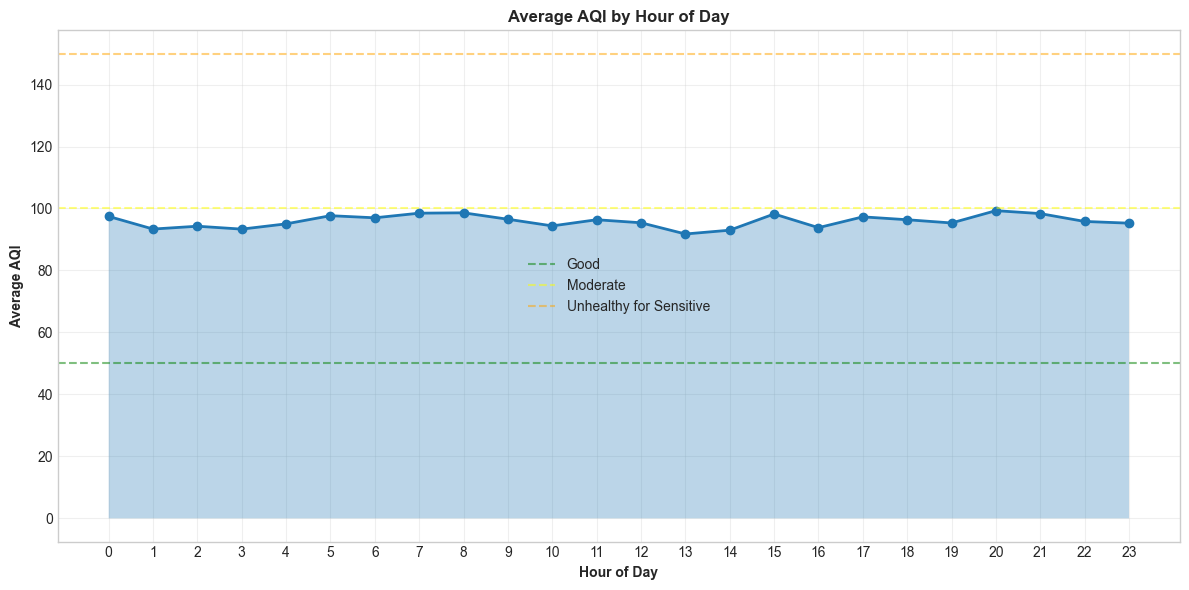

In [10]:
# =============================================================================
# 9. BEST TIME RECOMMENDATIONS
# =============================================================================

print("\n" + "=" * 70)
print("⏰ BEST TIME FOR OUTDOOR ACTIVITIES")
print("=" * 70)

# Analyze hourly patterns
if 'timestamp' in df_risk.columns:
    df_risk['hour'] = pd.to_datetime(df_risk['timestamp']).dt.hour
    hourly_avg = df_risk.groupby('hour')['aqi_predicted'].mean()
    
    # Find best and worst hours
    best_hour = hourly_avg.idxmin()
    worst_hour = hourly_avg.idxmax()
    
    print(f"\nBest time for outdoor activities:")
    print(f"  Hour: {best_hour}:00")
    print(f"  Average AQI: {hourly_avg[best_hour]:.1f}")
    print(f"  Category: {calculator.get_aqi_category(hourly_avg[best_hour]).value}")
    
    print(f"\nWorst time (avoid outdoor activities):")
    print(f"  Hour: {worst_hour}:00")
    print(f"  Average AQI: {hourly_avg[worst_hour]:.1f}")
    print(f"  Category: {calculator.get_aqi_category(hourly_avg[worst_hour]).value}")
    
    # Visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(hourly_avg.index, hourly_avg.values, marker='o', linewidth=2)
    ax.axhline(50, color='green', linestyle='--', alpha=0.5, label='Good')
    ax.axhline(100, color='yellow', linestyle='--', alpha=0.5, label='Moderate')
    ax.axhline(150, color='orange', linestyle='--', alpha=0.5, label='Unhealthy for Sensitive')
    ax.fill_between(hourly_avg.index, 0, hourly_avg.values, alpha=0.3)
    ax.set_xlabel('Hour of Day', fontweight='bold')
    ax.set_ylabel('Average AQI', fontweight='bold')
    ax.set_title('Average AQI by Hour of Day', fontweight='bold')
    ax.set_xticks(range(0, 24))
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [11]:
# =============================================================================
# 10. SAVE RESULTS
# =============================================================================

print("\n" + "=" * 70)
print("💾 SAVING RESULTS")
print("=" * 70)

# Save risk assessments
output_dir = Path('../data/processed')
risk_path = output_dir / 'health_risk_assessments.csv'
df_risk.to_csv(risk_path, index=False)
print(f"✓ Saved: {risk_path}")

# Save vulnerable group analysis
group_impact_df = pd.DataFrame(group_impact).T
group_impact_path = output_dir / 'vulnerable_group_impact.csv'
group_impact_df.to_csv(group_impact_path)
print(f"✓ Saved: {group_impact_path}")

# Save hourly recommendations
if 'hour' in df_risk.columns:
    hourly_path = output_dir / 'hourly_recommendations.csv'
    hourly_avg.to_frame('avg_aqi').to_csv(hourly_path)
    print(f"✓ Saved: {hourly_path}")

print("\n" + "=" * 70)
print("✅ HEALTH RISK ASSESSMENT COMPLETE!")
print("=" * 70)

print("\n📊 Summary:")
print(f"  Total assessments: {len(df_risk):,}")
print(f"  High risk days: {len(df_risk[df_risk['risk_level'].isin(['High', 'Very High', 'Extreme'])]):,}")
print(f"  Best hour for outdoors: {best_hour}:00")
print(f"  Vulnerable groups analyzed: {len(vulnerable_groups_list)}")

print("\n🎯 Next Steps:")
print("1. Integrate with backend API")
print("2. Create frontend dashboard")
print("3. Add real-time predictions")
print("4. Deploy health risk alerts")


💾 SAVING RESULTS
✓ Saved: ..\data\processed\health_risk_assessments.csv
✓ Saved: ..\data\processed\vulnerable_group_impact.csv
✓ Saved: ..\data\processed\hourly_recommendations.csv

✅ HEALTH RISK ASSESSMENT COMPLETE!

📊 Summary:
  Total assessments: 3,384
  High risk days: 1,072
  Best hour for outdoors: 13:00
  Vulnerable groups analyzed: 4

🎯 Next Steps:
1. Integrate with backend API
2. Create frontend dashboard
3. Add real-time predictions
4. Deploy health risk alerts
